# Topic modelling with Gensim : the LDA algorithm

LDA is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar.

### 1. Loading of the required libraries and vocabularies.
***



In [1]:
import gensim
import pandas as pd
import numpy as np

#import spacy
#import sys

## Run once this chunk with the command below active. Then comment it out and run the notebook
#!{sys.executable} -m spacy download en

#nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

import re
import pprint

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from pprint import pprint



### Step 2. Pre-processing

* Read two files exported from the database which contain the SE Glossary articles definitions and their titles, specifically the tables **ESTAT.V1.dat_concept** and **ESTAT.V1.dat_link_info**, respectively.
* In later versions, the **corresponding tables will be directly exported from the database**.
* Merge these two files by _id_ and discard records with duplicate titles and/or definitions.
* Apply some cleansing steps: replace anything except digits,letters,commas and dots by space, remove more than one spaces, delete spaces before commas. 

There are 1284 articles available for the analysis.


In [2]:
dat1= pd.read_csv("ESTAT_dat_concepts_2021_04_08.csv",sep=";")  ## table ESTAT.V1.dat_concept
dat2= pd.read_csv("ESTAT_dat_link_info_2021_04_08.csv",sep=";") ## ESTAT.V1.dat_link_info
Gloss_concepts = pd.merge(dat1,dat2,on=['id'])
del(dat1,dat2)

Gloss_concepts = Gloss_concepts[['id','title','definition']]

Gloss_concepts = Gloss_concepts.drop_duplicates(subset=["definition"])
Gloss_concepts = Gloss_concepts.dropna(axis=0,subset=["definition"])
Gloss_concepts = Gloss_concepts.drop_duplicates(subset=["title"])
Gloss_concepts = Gloss_concepts.dropna(axis=0,subset=["title"])

Gloss_concepts['definition'] = Gloss_concepts['definition'].apply(lambda x: re.sub("[^a-z\\.,A-Z]", " ",x)) ## replace anything except digits,letters,comma and dot by space 
Gloss_concepts['definition'] = Gloss_concepts['definition'].apply(lambda x: re.sub(' +', ' ',x)) ## remove more than one spaces
Gloss_concepts['definition'] = Gloss_concepts['definition'].apply(lambda x: re.sub('^ +| +$', '',x)) ## remove start and end spaces
Gloss_concepts['definition'] = Gloss_concepts['definition'].apply(lambda x: re.sub(' ,',',',x)) ## space-comma-space -> comma-space


Gloss_concepts.reset_index(drop=True, inplace=True)
Gloss_concepts


,id,title,definition
0,1,Arrival of tourist at a tourist accommodation ...,See arrival disambiguation page for other mean...
1,3,Nights spent,A night spent or tourism night overnight stay ...
2,4,Supply side tourism statistics,Regulation EU No of July establishes a common ...
3,5,Tourist,"For tourism statistics, a traveller is someone..."
4,7,Asia-Europe Meeting (ASEM),"The Asia Europe Meeting, abbreviated as ASEM, ..."
...,...,...,...
1279,2879,Statistical territory,The statistical territory of the European Unio...
1280,2881,Statistical indicator,A statistical indicator is the representation ...
1281,2885,Tourism industries,For the article Tourism industries economic an...
1282,2891,Sawnwood,Sawnwood is wood that has been produced either...


### 3. Pre-processing input data (cont).
***

Next we define a function _sent_to_words_ which accepts a series of texts and:
* Converts everything to lowercase and drops accents, 
* Deletes stop words, 
* Tokenizes the texts, 
* Apply Porter's stemmer and keeps as final tokens the resulting terms with minimum length 5. 

We call this function with the articles definitions in column "definition" of dataframe _Gloss_concepts_. The result, _texts_ is a nested list with 1284 outer elements corresponding to the articles. The inner lists contain the tokens for each text.

In [3]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.porter import PorterStemmer
def sent_to_words(sentences):
    p = PorterStemmer()
    for sentence in sentences:
        sentence = str(gensim.utils.simple_preprocess(sentence, deacc=True))
        sentence = remove_stopwords(sentence) 
        tokens = gensim.utils.tokenize(sentence)
        sentence = [p.stem(token) for token in tokens if len(p.stem(token)) >= 5] ##minimum length = 5 
        yield(sentence)
                
texts = list(sent_to_words(Gloss_concepts['definition']))
#texts = list(sent_to_words(Gloss_concepts['definition']))
print('\nFirst 5 texts: \n',texts[:5])
print('\nTotal texts: ',len(texts),'\n')



First 5 texts: 
 [['arriv', 'disambigu', 'other', 'arriv', 'within', 'context', 'european', 'union', 'tourism', 'statist', 'arriv', 'defin', 'tourist', 'arriv', 'tourist', 'accommod', 'establish', 'accommod', 'accommod', 'scope', 'tourism', 'regul', 'howev', 'latter', 'collect', 'tourist', 'either', 'resid', 'resid', 'countri', 'where', 'establish', 'locat', 'limit', 'appli', 'children', 'count', 'adult', 'overnight', 'children', 'might', 'charg'], ['night', 'spent', 'tourism', 'night', 'overnight', 'night', 'guest', 'tourist', 'resid', 'resid', 'actual', 'spend', 'sleep', 'tourist', 'accommod', 'establish', 'accommod'], ['regul', 'establish', 'common', 'framework', 'systemat', 'develop', 'product', 'dissemin', 'european', 'statist', 'tourism', 'purpos', 'member', 'state', 'transmit', 'harmonis', 'statist', 'tourism', 'suppli', 'demand', 'tourism', 'suppli', 'statist', 'accommod', 'statist', 'accommod', 'capac', 'occup', 'tourist', 'accommod', 'establish', 'report', 'countri', 'resid'

### 4. Creation of corpus and terms frequencies.
***

The next steps are:
* Create a vocabulary from _texts_ with name _id2word_. This is a dictionary with keys the numeric ids of the terms and the terms themselves as values. The terms are initially sorted alphabetically.
* Filter-out words which appear in less than 1% of the texts or in more than 80% of the texts. The result is 722 unique tokens.
* Create a mapping with name _corpus_ of texts to terms in the bag-of-words (BOW) format. Each text is mapped into a list with 2-tuples: (word id, word count in each text). Note that the **ordering of the terms in the _id2word_ vocabulary changes** (into the order of appearance in the texts).


In [4]:

from gensim import corpora

#Create Dictionary
id2word = corpora.Dictionary(texts) #Gensim creates a unique id for each word in the document. 
id2word.filter_extremes(no_below=0.01*len(texts), no_above=0.8)

print(id2word,'\n')

corpus = [id2word.doc2bow(text) for text in texts] 

print('First 5 texts in BOW format:\n')
print(corpus[:5],'\n')
print('First 5 texts in BOW format together with terms:\n')
for i in range(5):
    print([(id2word[term_id],term_id,freq) for (term_id,freq) in corpus[i]])

print('\nTotal texts: ',len(corpus))

Dictionary(722 unique tokens: ['accommod', 'adult', 'appli', 'arriv', 'charg']...) 

First 5 texts in BOW format:

[[(0, 3), (1, 1), (2, 1), (3, 4), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 2), (26, 3), (27, 1), (28, 1), (29, 1)], [(0, 2), (13, 1), (22, 2), (25, 1), (26, 2), (30, 1), (31, 1), (32, 1)], [(0, 3), (9, 4), (13, 2), (14, 1), (21, 1), (22, 5), (24, 5), (25, 6), (26, 1), (33, 1), (34, 2), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 4), (49, 1), (50, 2)], [(9, 1), (18, 1), (20, 2), (22, 1), (24, 1), (25, 2), (26, 1), (46, 3), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 2), (65, 1)], [(9, 1), (14, 1), (27, 1), (42, 3), (49, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1),

### 5. Grid search for the selection of the best LDA model.
***
The parameters in the call of the function _ldamodel.LdaModel()_ and the number of topics were selected by trial and error and also through **grid search runs**. The following dataframe and plot show the results of one **indicative** such run with a **subset** of the hyper-parameters. We run several such runs with different combinations and values for the hyper-parameters. 

Note that some parameters in the search (not shown in this example) were not related to the call to _gensim.models.ldamodel.LdaModel() function._ Examples were the lower and upper bounds on the appearance of terms in the texts.

The quality measure for the selection of the best LDA model is the coherence score. This is based on the work in Röder, M., Both, A., & Hinneburg, A. (2015, February). Exploring the space of topic coherence measures. In *Proceedings of the eighth ACM international conference on Web search and data mining* (pp. 399-408), available [here](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf). 



In [5]:
grid = pd.read_excel('grid.xlsx',index_col=0)   
grid

,num_topics,passes,alpha,decay,iterations,Coherence
0,18,10,symmetric,0.50,250,0.403904
1,18,10,symmetric,0.50,500,0.405463
2,18,10,symmetric,0.75,250,0.382357
3,18,10,symmetric,0.75,500,0.388442
4,18,10,symmetric,1.00,250,0.361309
...,...,...,...,...,...,...
103,22,50,auto,0.50,500,0.421268
104,22,50,auto,0.75,250,0.417549
105,22,50,auto,0.75,500,0.417838
106,22,50,auto,1.00,250,0.401768


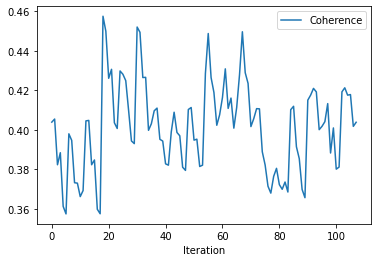

In [6]:
grid.plot.line(y='Coherence')
_ = plt.xlabel("Iteration")

The (disabled) code for this **indicative** grid search is shown below. Do **not** comment-out the first line. 

In [7]:
%%script false --no-raise-error ## DO NOT UN-COMMENT THIS! THIS CELL IS NOT SUPPOSED TO RUN

from gensim.models import CoherenceModel
from itertools import product

def expand_grid(dictionary):
    return pd.DataFrame([row for row in product(*dictionary.values())], 
                       columns=dictionary.keys())

dictionary = {'num_topics':[18,20,22], 'passes': [10,50], 'alpha': ['symmetric', 'asymmetric','auto'], 
              'decay': [0.5, 0.75, 1], 'iterations':[250,500]}

grid = expand_grid(dictionary)
print(grid)
best_coherence = 0
best_params = -1
for i in range(len(grid)):
    
    print('Testing with row ',i+1,' of ',len(grid),'\n')
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=grid.loc[i,'num_topics'],
                                           random_state=100,
                                           update_every=0,
                                           passes=grid.loc[i,'passes'],
                                           alpha=grid.loc[i,'alpha'],
                                           iterations=grid.loc[i,'iterations'],
                                           decay = grid.loc[i,'decay'],
                                           per_word_topics=True)
    
    print(grid.loc[i,:])
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda,'\n')
    grid.loc[i,'Coherence'] = coherence_lda
    
    if coherence_lda > best_coherence:
        best_coherence = coherence_lda
        best_params = i
        
    print('\nBest so far: ',best_coherence,' at row ',best_params,'\n')    

    grid.to_excel('grid.xlsx')

### 6. Fitting the selected LDA model
***

The next code shows the fitting of the LDA model with the selected parameters found (20 topics). These are not exactly the ones shown in the indicative grid search shown previously. For example, we found that we had to lower a little the _decay_ parameter. The coherence value of 0.45 is considered adequate. We store the fitted model in an object _lda_model_.

In [8]:
#Build LDA model

num_topics = 20
passes = 50
alpha='symmetric'
iterations = 500
decay = 0.40

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=0,
                                           passes=passes,
                                           alpha=alpha,
                                           iterations=iterations,
                                           decay = decay,
                                           per_word_topics=True)


from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4491003305887665


### 7. Identification of the dominant topic per document.
***
In this section, we identify the dominant topic, its weight and its keywords, for each document. We define a dataframe _df_topic_sents_keywords_  in order to store these results. As it will be seen later, these are very useful as **complementary information to find and/or verify the interpretation of the topics**.

In function _format_topics_sentences()_ below, the list _ldamodel[corpus]_ has one nested list element per text. Each nested list contains tuples of the form (topic, contribution). We sort the firts element of each nested list by descending contribution to find the dominant topic and then, we retrieve for this topic, the list _wp_ of tuples (word, probability) for the most probable words, using the function _ldamodel.show_topic()_. We join these words into a list and put the result in column 'Topic_Keywords' of the dataframe.  


In [9]:
def format_topics_sentences(ldamodel=None, corpus=corpus):

    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]): 
        row = row_list[0]
        row = sorted(row, key=lambda x: (x[1]), reverse=True) ## sort the nested list by descending contribution
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        topic_num, prop_topic = row[0]
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original tokenized text and title to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df = pd.concat([sent_topics_df, Gloss_concepts['id'],Gloss_concepts['title']], axis=1)
    return(sent_topics_df)

In [10]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus)
df_topic_sents_keywords.rename(columns = {0:'Text tokenized definition'}, inplace = True)
df_topic_sents_keywords.rename(columns = {'id':'Text id','title':'Text title'}, inplace = True)
df_topic_sents_keywords = df_topic_sents_keywords[['Text id','Text title','Text tokenized definition','Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']]
df_topic_sents_keywords['Dominant_Topic'] = df_topic_sents_keywords['Dominant_Topic'].astype(int)
df_topic_sents_keywords


,Text id,Text title,Text tokenized definition,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,1,Arrival of tourist at a tourist accommodation ...,"[arriv, disambigu, other, arriv, within, conte...",9,0.4575,"servic, transport, includ, other, vehicl, plac..."
1,3,Nights spent,"[night, spent, tourism, night, overnight, nigh...",9,0.9208,"servic, transport, includ, other, vehicl, plac..."
2,4,Supply side tourism statistics,"[regul, establish, common, framework, systemat...",9,0.4029,"servic, transport, includ, other, vehicl, plac..."
3,5,Tourist,"[tourism, statist, travel, someon, between, di...",9,0.5643,"servic, transport, includ, other, vehicl, plac..."
4,7,Asia-Europe Meeting (ASEM),"[europ, abbrevi, inform, process, dialogu, whi...",5,0.4673,"european, state, member, union, regul, council..."
...,...,...,...,...,...,...
1279,2879,Statistical territory,"[statist, territori, european, union, context,...",19,0.9694,"countri, state, resid, member, trade, european..."
1280,2881,Statistical indicator,"[statist, indic, represent, statist, specifi, ...",5,0.2498,"european, state, member, union, regul, council..."
1281,2885,Tourism industries,"[articl, tourism, industri, econom, analysi, t...",9,0.9204,"servic, transport, includ, other, vehicl, plac..."
1282,2891,Sawnwood,"[sawnwood, produc, either, lengthwai, profil, ...",0,0.6750,"product, process, energi, innov, method, techn..."


### 8. Most representative document for each topic.
***

Here, we are searching for the reverse, i.e. we want to find the document that best represents a given topic.We create the dataframe _sent_topics_sorteddf_mallet_ to store the results.

In [11]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords[['Text id','Text title','Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']].groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                             axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

sent_topics_sorteddf_mallet.columns = ['Text id','Text title','Topic_Num', 'Topic_Perc_Contrib', 'Topic Keywords' ]
sent_topics_sorteddf_mallet = sent_topics_sorteddf_mallet[['Topic_Num', 'Topic_Perc_Contrib', 'Topic Keywords','Text id','Text title']]

sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Topic Keywords,Text id,Text title
0,0,0.9798,"product, process, energi, innov, method, techn...",1625,Technological product and process innovatio...
1,1,0.9779,"activ, classif, statist, level, group, health,...",249,International patent classification (IPC)
2,2,0.9872,"person, labour, emploi, activ, peopl, employ, ...",1268,Activation policies
3,3,0.9860,"number, popul, death, enterpris, statist, peri...",206,Population change
4,4,0.9891,"develop, environment, research, econom, accoun...",1455,Joint health accounts data collection
5,5,0.9887,"european, state, member, union, regul, council...",321,Stability and growth pact (SGP)
6,6,0.9500,"incom, social, govern, household, expenditur, ...",164,Disposable income
7,7,0.9793,"product, consumpt, import, gross, materi, dome...",155,Recovery of waste
8,8,0.9901,"build, livestock, construct, internet, which, ...",624,Building
9,9,0.9548,"servic, transport, includ, other, vehicl, plac...",154,Landfill


### 9. The topics as a mix of keywords.
***

The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes with a certain weight to the topic.  This mix of keywords (limited to the top 10 keywords) is shown below, for each topic.


In [12]:
pprint(lda_model.print_topics())

## equivalently:
##for i in range(num_topics):
##    print([(id2word[term_id],prob) for (term_id,prob) in lda_model.get_topic_terms(i,topn=10)],'\n')

[(0,
  '0.117*"product" + 0.064*"process" + 0.060*"energi" + 0.052*"innov" + '
  '0.025*"method" + 0.022*"technolog" + 0.022*"other" + 0.022*"forecast" + '
  '0.020*"market" + 0.020*"improv"'),
 (1,
  '0.091*"activ" + 0.058*"classif" + 0.051*"statist" + 0.032*"level" + '
  '0.032*"group" + 0.030*"health" + 0.020*"classifi" + 0.020*"accord" + '
  '0.020*"class" + 0.019*"section"'),
 (2,
  '0.040*"person" + 0.037*"labour" + 0.035*"emploi" + 0.031*"activ" + '
  '0.028*"peopl" + 0.026*"employ" + 0.022*"enterpris" + 0.018*"measur" + '
  '0.015*"those" + 0.015*"worker"'),
 (3,
  '0.055*"number" + 0.047*"popul" + 0.039*"death" + 0.031*"enterpris" + '
  '0.025*"statist" + 0.021*"period" + 0.017*"averag" + 0.017*"birth" + '
  '0.017*"refer" + 0.017*"chang"'),
 (4,
  '0.055*"develop" + 0.029*"environment" + 0.028*"research" + 0.028*"econom" + '
  '0.025*"account" + 0.025*"health" + 0.022*"nation" + 0.022*"manag" + '
  '0.019*"resourc" + 0.018*"system"'),
 (5,
  '0.089*"european" + 0.058*"state" 

### 10. Dominant topics.
***


To better understand the volume and distribution of topics, we construct the dataframe _df_dominant_topics_ with relevant information.


In [13]:
#Topic distribution across documents

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,9,"servic, transport, includ, other, vehicl, plac...",71.0,0.0553
1,9,"servic, transport, includ, other, vehicl, plac...",53.0,0.0413
2,9,"servic, transport, includ, other, vehicl, plac...",70.0,0.0545
3,9,"servic, transport, includ, other, vehicl, plac...",119.0,0.0927
4,5,"european, state, member, union, regul, council...",69.0,0.0537
...,...,...,...,...
1279,19,"countri, state, resid, member, trade, european...",NaN,NaN
1280,5,"european, state, member, union, regul, council...",NaN,NaN
1281,9,"servic, transport, includ, other, vehicl, plac...",NaN,NaN
1282,0,"product, process, energi, innov, method, techn...",NaN,NaN


### 11. Visualization of the topics.
***

To visualize the fitted LDA model we use the _pyLDAvis_ package. This is the Python porting of the R package _LDAvis_, see [LDAvis vignette](https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf) for details and Chuang, Jason, Manning, Christopher D., and Heer, Jeffrey (2012). Termite: Visualization Techniques for Assessing Textual Topic Models, *Advanced Visual Interfaces* for the theory behind the visualization algorithm. The paper is available [here](https://dl.acm.org/doi/pdf/10.1145/2254556.2254572?casa_token=q2BavKP415QAAAAA:MhcYHzz4PJpC7dNkkm12GL-ohQRUXBgumPJ9l1t_5n3M4qVE1kdDqKGfPmtnR7qbale_ukS-2nJs). 

Note that the parameter _sort_topics=False_ in the call to function _pyLDAvis.gensim_models.prepare()_ is necessary, otherwise the numbering of the topics is different than the one in the rest of the analysis. Also, **the numbering of the topics start from zero**.

In [14]:
#Visualize the topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word,sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.163265 -0.020623       1        1  4.479166
1     -0.100188  0.011364       2        1  4.583703
2     -0.000023  0.032194       3        1  5.266228
3      0.011748  0.125353       4        1  6.551266
4     -0.066723 -0.098527       5        1  5.957222
5     -0.229401 -0.099239       6        1  7.643530
6      0.091452 -0.194399       7        1  7.498033
7      0.229822 -0.149553       8        1  5.160248
8      0.030714  0.134269       9        1  3.191233
9      0.057621  0.064553      10        1  4.665995
10     0.053688  0.161281      11        1  3.928929
11    -0.049247  0.098166      12        1  5.677884
12     0.063465 -0.053851      13        1  4.712134
13    -0.081089  0.006650      14        1  3.886460
14    -0.061913  0.157200      15        1  3.680663
15    -0.213025  0.004229      16        1  3.563671
16     0.076870 -0.232688      17        1  5.426330
17     0.076829  0.094843      18        1  3.763760
18     0.148570  0.088375      19        1  4.018818
19    -0.202435 -0.129598      20        1  6.344726, topic_info=         Term        Freq       Total Category  logprob  loglift
45    product  726.000000  726.000000  Default  30.0000  30.0000
9     countri  535.000000  535.000000  Default  29.0000  29.0000
14   european  545.000000  545.000000  Default  28.0000  28.0000
145   financi  247.000000  247.000000  Default  27.0000  27.0000
318     price  238.000000  238.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
82     nation   33.158022  351.174738  Topic20  -4.5763   0.3975
24    statist   34.646563  505.599828  Topic20  -4.5324   0.0770
20      other   30.968841  620.285937  Topic20  -4.6446  -0.2397
58     includ   24.134626  599.845726  Topic20  -4.8939  -0.4555
29     within   23.962477  160.717783  Topic20  -4.9011   0.8544

[943 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
66        1  0.009776  abbrevi
66        2  0.175967  abbrevi
66        3  0.029328  abbrevi
66        4  0.024440  abbrevi
66        5  0.122199  abbrevi
...     ...       ...      ...
89       17  0.151336    world
89       20  0.408606    world
367       7  0.081353    yield
367      10  0.040676    yield
367      19  0.813527    yield

[3303 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

### 12. Interpretation of the topics and topic coherences.
***

For the interpretation of the topics, we inspect this visualization together:  
* with the information on the decomposition of topics into its main keywords (i.e. the same information as in 9. "The topics as a mix of keywords"). In each topic, the main keywords are here sorted by descending importance and plots are produced.
* with the information on the most representative article for each topic, see 8. "Most representative document for each topic".


Topic id:  1
('product', 0.11731217)
('process', 0.063915454)
('energi', 0.060065728)
('innov', 0.051585555)
('method', 0.025442893)
('technolog', 0.02202184)
('other', 0.021881389)
('forecast', 0.021526333)
('market', 0.020476595)
('improv', 0.019799156)


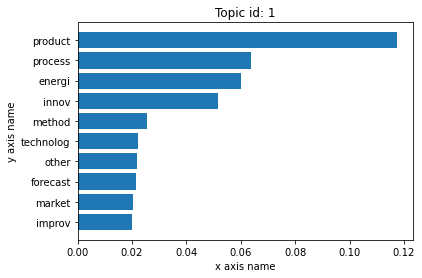


Topic id:  2
('activ', 0.09091463)
('classif', 0.05786043)
('statist', 0.050667513)
('level', 0.031890403)
('group', 0.03179693)
('health', 0.030190563)
('classifi', 0.020357922)
('accord', 0.020335115)
('class', 0.019909887)
('section', 0.018718943)


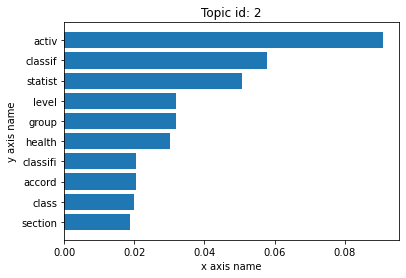


Topic id:  3
('person', 0.039996583)
('labour', 0.037203457)
('emploi', 0.03524415)
('activ', 0.03140044)
('peopl', 0.02835984)
('employ', 0.025590083)
('enterpris', 0.0222397)
('measur', 0.018331151)
('those', 0.015178265)
('worker', 0.014969832)


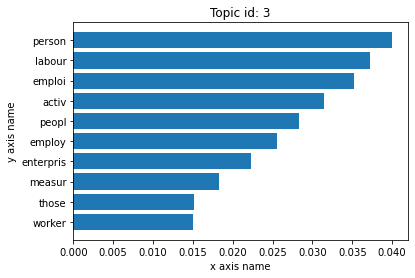


Topic id:  4
('number', 0.054755706)
('popul', 0.046817247)
('death', 0.038939256)
('enterpris', 0.030937888)
('statist', 0.025164189)
('period', 0.020877393)
('averag', 0.017202195)
('birth', 0.0171718)
('refer', 0.016912658)
('chang', 0.016554728)


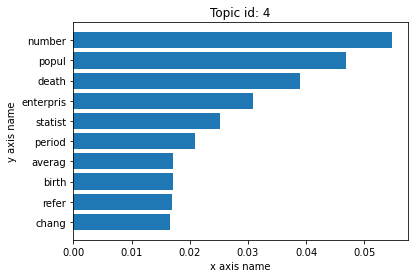


Topic id:  5
('develop', 0.054754652)
('environment', 0.028651496)
('research', 0.02814057)
('econom', 0.02790306)
('account', 0.025280276)
('health', 0.02493902)
('nation', 0.022281975)
('manag', 0.022046905)
('resourc', 0.019404123)
('system', 0.018358873)


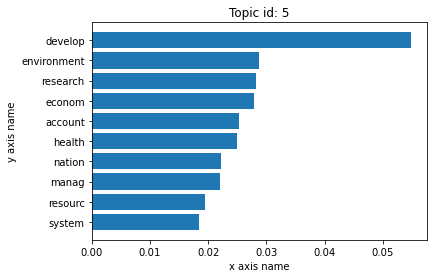


Topic id:  6
('european', 0.08894015)
('state', 0.057910435)
('member', 0.05176551)
('union', 0.044704996)
('regul', 0.020880932)
('council', 0.017956812)
('commiss', 0.017806606)
('abbrevi', 0.01577448)
('econom', 0.015505519)
('nation', 0.015173724)


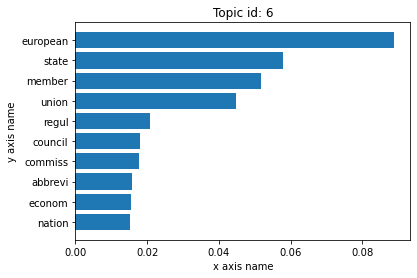


Topic id:  7
('incom', 0.07221323)
('social', 0.060823966)
('govern', 0.048985653)
('household', 0.028506322)
('expenditur', 0.028346391)
('transfer', 0.027833411)
('contribut', 0.025606578)
('other', 0.021506434)
('current', 0.020719621)
('gross', 0.01949682)


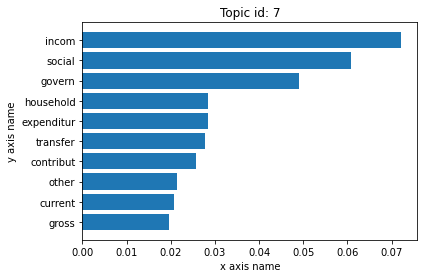


Topic id:  8
('product', 0.10510526)
('consumpt', 0.05136058)
('import', 0.040452506)
('gross', 0.03947462)
('materi', 0.03440214)
('domest', 0.031307288)
('servic', 0.02964641)
('produc', 0.026699798)
('input', 0.026628569)
('output', 0.025967771)


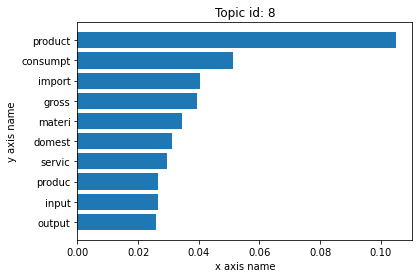


Topic id:  9
('build', 0.051410273)
('livestock', 0.050145764)
('construct', 0.03228549)
('internet', 0.028692601)
('which', 0.023573408)
('access', 0.02330618)
('purpos', 0.019100435)
('inform', 0.018365622)
('target', 0.018350346)
('system', 0.018265791)


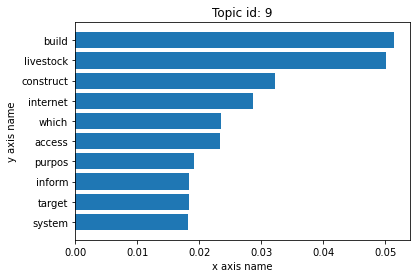


Topic id:  10
('servic', 0.081075266)
('transport', 0.06570737)
('includ', 0.04941576)
('other', 0.04357526)
('vehicl', 0.031172)
('place', 0.02642899)
('exclud', 0.02192732)
('tourism', 0.021554459)
('accommod', 0.021140408)
('facil', 0.016019491)


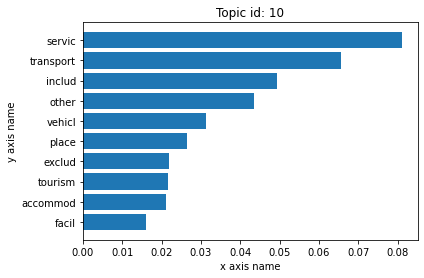


Topic id:  11
('manur', 0.06495701)
('cover', 0.0364422)
('surfac', 0.029763268)
('where', 0.029708426)
('water', 0.027779466)
('permit', 0.025516033)
('emiss', 0.021661865)
('liquid', 0.021634016)
('remov', 0.020375045)
('solid', 0.019355554)


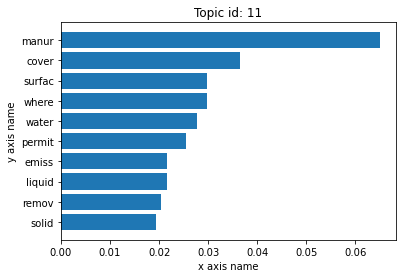


Topic id:  12
('survei', 0.06855535)
('agricultur', 0.06339304)
('household', 0.034384247)
('indic', 0.031345997)
('person', 0.024465675)
('activ', 0.023798646)
('collect', 0.02017189)
('famili', 0.01773456)
('carri', 0.017498564)
('which', 0.016980166)


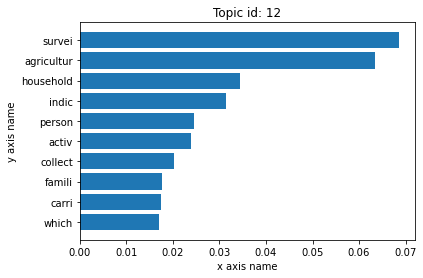


Topic id:  13
('price', 0.09331014)
('index', 0.05805206)
('indic', 0.055659167)
('calcul', 0.026969675)
('measur', 0.024143128)
('consum', 0.021182375)
('servic', 0.021129765)
('period', 0.021127919)
('countri', 0.021007389)
('purchas', 0.019580726)


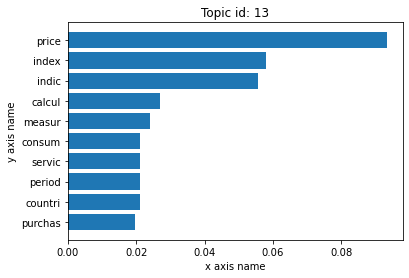


Topic id:  14
('applic', 0.06214084)
('protect', 0.054475892)
('person', 0.03832459)
('direct', 0.027424196)
('intern', 0.027383065)
('decis', 0.026986284)
('nation', 0.026656993)
('countri', 0.021943316)
('refer', 0.021721832)
('grant', 0.021708855)


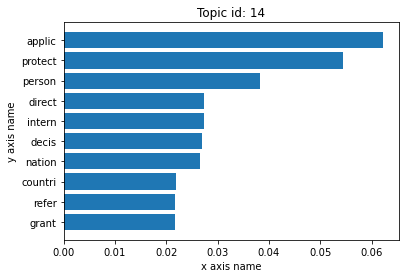


Topic id:  15
('statist', 0.07006088)
('refer', 0.047068592)
('which', 0.035756644)
('inform', 0.027004795)
('collect', 0.026411714)
('locat', 0.024062335)
('between', 0.02375972)
('point', 0.022339884)
('water', 0.020611601)
('variabl', 0.019334015)


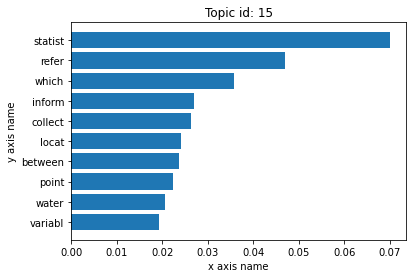


Topic id:  16
('region', 0.08023088)
('enterpris', 0.040145483)
('legal', 0.033553537)
('local', 0.029726794)
('urban', 0.028674528)
('popul', 0.027526245)
('common', 0.024182728)
('level', 0.023215717)
('countri', 0.022599282)
('central', 0.021231215)


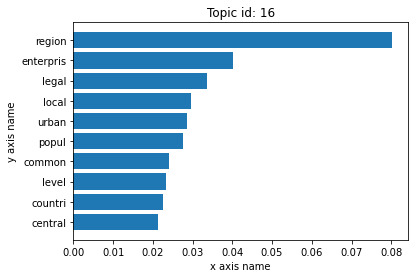


Topic id:  17
('financi', 0.08767944)
('account', 0.06572519)
('asset', 0.050850376)
('market', 0.037662234)
('sector', 0.032828514)
('institut', 0.030372936)
('liabil', 0.021842802)
('produc', 0.020902418)
('transact', 0.020254428)
('nation', 0.017791132)


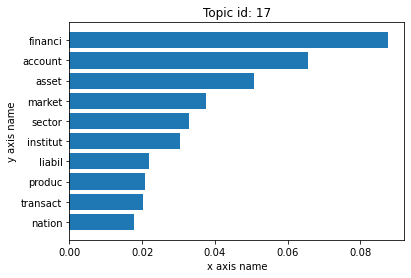


Topic id:  18
('weight', 0.049227804)
('employ', 0.029208407)
('employe', 0.025691032)
('averag', 0.022980878)
('total', 0.022640657)
('labour', 0.022492213)
('technolog', 0.021092383)
('number', 0.020765753)
('level', 0.018209465)
('period', 0.016052237)


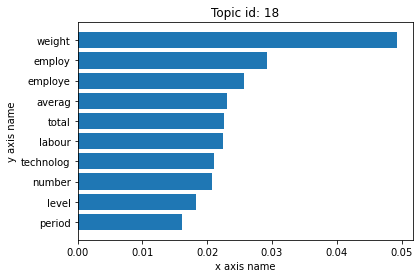


Topic id:  19
('plant', 0.03843266)
('product', 0.038380403)
('includ', 0.037350867)
('which', 0.035942033)
('other', 0.03310402)
('perman', 0.027402941)
('harvest', 0.026915172)
('agricultur', 0.026863033)
('exclud', 0.025235381)
('arabl', 0.020662999)


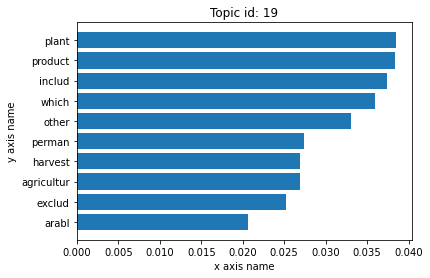


Topic id:  20
('countri', 0.10166938)
('state', 0.039614502)
('resid', 0.037970055)
('member', 0.036607936)
('trade', 0.033784688)
('european', 0.027595118)
('union', 0.022387318)
('intern', 0.018052818)
('januari', 0.016192736)
('econom', 0.015004549)


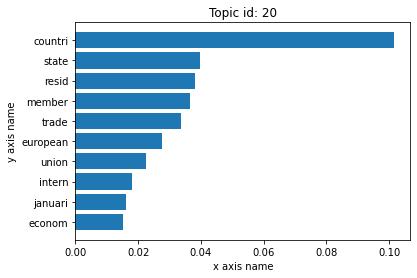

In [15]:

   
for topic_id in range(num_topics):
    print('\nTopic id: ',topic_id+1 )
    top_words = [(a,b) for (a,b) in sorted(lda_model.show_topic(topic_id,topn=10),key=lambda x: x[1], reverse=True)]
    for t in range(len(top_words)):
        print(top_words[t])
    y_axis = [t[0] for t in top_words]
    x_axis = [t[1] for t in top_words] 
    
    plt.barh(y_axis,x_axis)
    plt.gca().invert_yaxis()
    plt.title('title name')
    plt.ylabel('y axis name')
    plt.xlabel('x axis name')
    plt.title('Topic id: '+str(topic_id+1))
    plt.show()        




We end-up with the following interpretations of the 20 topics. Together with the topic names, we also give the coherence scores by topic. We can see that topic 7 "Social expenditure and households income" has the highest coherence while topic 9 "Buildings and construction" has the lowest.   


Topic  1. Coherence: 0.323164  Technological product and process innovation.  
Topic  2. Coherence: 0.426354  Statistical classification of activities.  
Topic  3. Coherence: 0.382280  Persons and employment.  
Topic  4. Coherence: 0.472150  Population and demography.  
Topic  5. Coherence: 0.377429  Environmental and health accounts.  
Topic  6. Coherence: 0.628774  EU, Member States and legislature.  
Topic  7. Coherence: 0.770273  Social expenditure and households income.  
Topic  8. Coherence: 0.518405  Production, consumption and gross accounts.  
Topic  9. Coherence: 0.246925  Buildings and construction.  
Topic 10. Coherence: 0.465399  Transport and tourist accommodation.  
Topic 11. Coherence: 0.501314  Farming and land resources.  
Topic 12. Coherence: 0.437938  Agriculture and surveillance.  
Topic 13. Coherence: 0.440314  Price indices and calculations.  
Topic 14. Coherence: 0.524101  Protection applications and asylum grants.  
Topic 15. Coherence: 0.314013  Statistical co

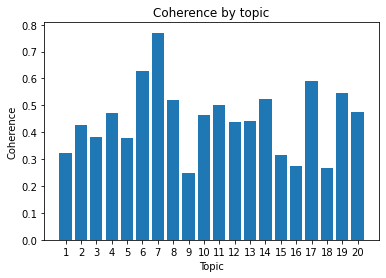

In [16]:
topic_names = [
'Technological product and process innovation',    
'Statistical classification of activities',    
'Persons and employment',   
'Population and demography',
'Environmental and health accounts',
'EU, Member States and legislature',
'Social expenditure and households income',
'Production, consumption and gross accounts',
'Buildings and construction',
'Transport and tourist accommodation',
'Farming and land resources',
'Agriculture and surveillance',
'Price indices and calculations',   
'Protection applications and asylum grants',    
'Statistical collections and reference periods',
'Regions, business demography and urbanization',    
'Financial market sector',
'Employment measurement',
'Agriculture and harvesting',
'EU trade and the Member States']    

coh_topics = coherence_model_lda.get_coherence_per_topic(segmented_topics=None,with_std=False, with_support=False)

for (i,tn) in enumerate(topic_names):
    print('Topic {0:2d}. Coherence: {1:6f}  {2:s}.  '.format(i+1,coh_topics[i],tn))

fig, ax = plt.subplots()
x=np.arange(num_topics)+1
plt.bar(x=x,height=coh_topics)
plt.xlabel("Topic")
plt.ylabel("Coherence")
plt.title("Coherence by topic")
ax.set_xticks(x)
plt.show()
    

### 13. Outputs.
***

A first output in dataframe _topics_terms_df_ is for inspection only: a 20 x 722 matrix with the distribution of terms per topic. The row sums of this matrix are ones. 

In [17]:

topics_terms_mat = lda_model.get_topics()
print(topics_terms_mat.shape)
topics_terms_df = pd.DataFrame()
for topic_id in range(num_topics):
    topics_terms_df = topics_terms_df.append(pd.Series(topics_terms_mat[topic_id,:].transpose()), ignore_index=True)           
topics_terms_df.rename(columns=id2word, inplace=True)
topics_terms_df.insert(0,'Topic Name',topic_names)
print(topics_terms_df)
topics_terms_df.to_csv('topics_terms_df.write_csv',sep=';')

(20, 722)
                                       Topic Name  accommod     adult  \
0    Technological product and process innovation  0.000022  0.000022   
1        Statistical classification of activities  0.000021  0.000021   
2                          Persons and employment  0.000019  0.000019   
3                       Population and demography  0.000015  0.000067   
4               Environmental and health accounts  0.000016  0.002979   
5               EU, Member States and legislature  0.000013  0.000013   
6        Social expenditure and households income  0.000013  0.000369   
7      Production, consumption and gross accounts  0.000019  0.000019   
8                      Buildings and construction  0.000030  0.011893   
9             Transport and tourist accommodation  0.021140  0.000021   
10                     Farming and land resources  0.000025  0.000025   
11                   Agriculture and surveillance  0.000017  0.000017   
12                 Price indices and calc

In [18]:
import numpy as np
np.sum(lda_model.get_topics(),axis=1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.0000001 , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 0.9999999 , 1.        , 0.9999999 , 1.        ],
      dtype=float32)

The next output is for **insertion into the database**. It is the previous matrix in (row,column,value) format, in dataframe _tm_values_, exported to file **_tm_values.csv_** (delimiter=semicolon). All indices are zero-based.

In [19]:
pd.options.display.float_format = '{:.8f}'.format
tm_values = pd.DataFrame(columns=['Topic id','Term id','Probability'])
count = -1
for i in range(topics_terms_mat.shape[0]):
    for j in range(topics_terms_mat.shape[1]):
        count += 1
        tm_values.loc[count,'Topic id']=i
        tm_values.loc[count,'Term id']=j
        tm_values.loc[count,'Probability']=topics_terms_mat[i,j]

print(tm_values)
#pd.options.display.float_format = None
tm_values.to_csv('tm_values.csv',sep=';',index=False)

      Topic id Term id Probability
0            0       0  0.00002151
1            0       1  0.00002151
2            0       2  0.00002223
3            0       3  0.00002151
4            0       4  0.00002151
...        ...     ...         ...
14435       19     717  0.00001534
14436       19     718  0.00001534
14437       19     719  0.00001534
14438       19     720  0.00001534
14439       19     721  0.00001534

[14440 rows x 3 columns]


Dataframe _tm_topics_, exported into file **_tm_topics.csv_** (delimiter=semicolon) links the _tm_values_ with the topics information, with the zero-based _Topic id_ key. 

In [20]:
tm_topics = sent_topics_sorteddf_mallet.copy()
tm_topics.rename(columns={'Topic_Num':'Topic id'},inplace=True)
tm_topics.drop(columns=['Topic_Perc_Contrib','Text id','Text title'],inplace=True)
tm_topics = pd.concat([tm_topics, pd.Series(topic_names)],ignore_index=True,axis=1)
tm_topics.columns = ['Topic id', 'Topic keywords', 'Topic name']
print(tm_topics)
tm_topics.to_csv('tm_topics.csv',sep=';',index=False)

    Topic id                                     Topic keywords  \
0          0  product, process, energi, innov, method, techn...   
1          1  activ, classif, statist, level, group, health,...   
2          2  person, labour, emploi, activ, peopl, employ, ...   
3          3  number, popul, death, enterpris, statist, peri...   
4          4  develop, environment, research, econom, accoun...   
5          5  european, state, member, union, regul, council...   
6          6  incom, social, govern, household, expenditur, ...   
7          7  product, consumpt, import, gross, materi, dome...   
8          8  build, livestock, construct, internet, which, ...   
9          9  servic, transport, includ, other, vehicl, plac...   
10        10  manur, cover, surfac, where, water, permit, em...   
11        11  survei, agricultur, household, indic, person, ...   
12        12  price, index, indic, calcul, measur, consum, s...   
13        13  applic, protect, person, direct, intern, decis..

Similarly, dataframe _tm_terms_, exported into file **_tm_terms.csv_** (delimiter=semicolon) which links the _tm_values_ with the terms information, with the zero-based _Term id_ key. 

In [21]:
tm_terms = pd.DataFrame([id2word[t_id] for t_id in id2word],columns=['Term name'])
tm_terms.insert(0,value=range(len(id2word)),column='Term id') 
print(tm_terms)
tm_terms.to_csv('tm_terms.csv',sep=';',index=False)

     Term id  Term name
0          0   accommod
1          1      adult
2          2      appli
3          3      arriv
4          4      charg
..       ...        ...
717      717  irrespect
718      718     postal
719      719     length
720      720  paragraph
721      721  groundwat

[722 rows x 2 columns]
